## Before you begin
- please make sure you have installed following package by `pip`:

> ```pip install keras tensorflow pandas scikit-learn matplotlib```

- And also download [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/00331/) and [GloVe](http://nlp.stanford.edu/data/glove.6B.zip) pretrained word embeddings (822 MB).

> Sentiment Labelled Sentences Data Set 為zip檔，完解壓縮並放到與此notebook file同個路徑底下。

> pretrained word embeddings 中有許多維度的 embeddings，本篇教學僅使用到 `glove.6B.50d.txt`，故只要解壓縮該檔即可。

In [1]:
!ls *txt

amazon_cells_labelled.txt
glove.6B.50d.txt
imdb_labelled.txt
yelp_labelled.txt


# Introduction
original article: https://realpython.com/python-keras-text-classification/#choosing-a-data-set

此篇教學將帶你運用(deep) neural networks 做一遍所謂的「情感分析(sentiment analysis)」分類問題。

此篇教學使用的數據集來自UCI Machine Learning Repository，該數據包括來自IMDb，Amazon和Yelp的標記評論。
對於負面情緒給予0的標記；正面的情緒給予1的標記。

那我們就開始吧！

# Choosing a Data Set

首先我們將預載的資料集用`pandas`讀進來，然後串接起來看一下都長甚麼樣子：

In [2]:
import pandas as pd

filepath_dict = {'yelp':   './yelp_labelled.txt',
                 'amazon': './amazon_cells_labelled.txt',
                 'imdb':   './imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [3]:
df

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
5,Now I am getting angry and I want my damn pho.,0,yelp
6,Honeslty it didn't taste THAT fresh.),0,yelp
7,The potatoes were like rubber and you could te...,0,yelp
8,The fries were great too.,1,yelp
9,A great touch.,1,yelp


可以觀察到，總共有2748筆評論，每筆評論有一段 comment(即`sentence`)，並且有著0(負評)或1(正評)的標記。

我們的目的是預測一段評論句是「正評」還是「負評」。

直覺的作法是計算出每一個字出現在好/壞評論中的次數，並且從中找到關聯性。

若要這麼做首先我們得創建一個詞彙表(vocabulary)，此詞彙表則可以用我們蒐集起來的所有句子(corpus)來建立。

當我們有了詞彙表之後，就可以將一個句子轉換成特徵向量(feature vector)，此特徵向量的長度將會與詞彙表相同，並且計算一句評論中的每個單詞(word)出現的次數，填入特徵向量中對應的字詞的元素位置。

以下使用`CountVectorizer`示範此概念：

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

sentences = [
    'John likes ice cream', 
    'John hates chocolate'
]
vectorizer = CountVectorizer(min_df=0, lowercase=False)
    # 如果某個詞的文件頻率小於`min_df`，則這個詞不會被當作關鍵詞
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [5]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]], dtype=int64)

# Defining a Baseline Model

data set 有三種，拿 yelp 的部分來做初步實驗。

首先將 yelp  的 sentence 及 label 取出，並切出 25% 做為 testing set，其餘的是 training set。

In [6]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

sentences_train.shape, sentences_test.shape

((750,), (250,))

再來我們用`vectorizer.fit`以及 training set - `sentences_train` 建立詞彙表，再利用 vectorizer 將 `sentence_train/test` 轉成 feature vector - `X_train/test`。

可以觀察到，yelp 的 training set 有 750 個樣本；每一個樣本的 feature vector 長度為 1714。意味著我們用training set做出來的詞彙表總共有1747個詞彙。

`CountVectorizer` 幫我們做的事又可稱作 **Tokenization**，預設會去除標點符號與特殊字元，若有其他 tokenization 的需求，可以進一步去 [NLTK library](https://www.nltk.org/) 找找。

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

特徵向量都準備好了之後，我們使用 Logistic Regression 快速地訓練一個分類模型來當作我們後續的比較用的baseline model：

In [8]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


C:\Users\a2437\Anaconda3\envs\NLP_Practice\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


接著我們來瞧一瞧，每一個 data set 都各自訓練一個 baseline model

In [9]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)
    
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f} {}'.format(source, score, X_train.shape))


Accuracy for yelp data: 0.7960 (750, 1714)
Accuracy for amazon data: 0.7960 (750, 1546)
Accuracy for imdb data: 0.7487 (561, 2505)


# A Primer on (Deep) Neural Networks
***(原文中文字敘述的部分與程式碼不一致，已依照原文文字的描述調整成正確的程式碼)***

接著讓我們來稍微使用一下神經網絡的架構來處理此問題。

再拿 yelp 的資料集來當範例，重新從 `df` 中取出來...直到轉換成 `X_train` 及 `X_test`：

In [10]:
df_source = df[df['source'] == 'yelp']
sentences = df_source['sentence'].values
y = df_source['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

開始使用keras，在此建立一個僅含有 **1個hidden layer(5個nodes)** 的神經網絡。


hidden layer 的激發函數(activation)選擇 'relu'；output layer 由於是二元分類故選擇'sigmoid'作為輸出。

> Dense layer指的就是一般的全連接層(fully connected layer)，或可稱 [Affine layer](https://deepai.org/machine-learning-glossary-and-terms/affine-layer)

須注意要明確指定 input layer 的 size 跟我們每一筆 sample 的 feature vector 一致。除此之外的 layer 在使用 keras 時會自動對齊input-output sizes。

另外，**loss fuction**選擇'binary_crossentropy'；**optimizer**使用'adam'；評估方法(metrics)則選擇'accuracy'。


`compile` 完看一下 `summary`：

In [11]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]
print("Input size: {}".format(input_dim))
model = Sequential()
model.add(layers.Dense(5, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Input size: 1714
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 8575      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________


稍微解釋一下此summary的資訊：
- 拿 yelp 的樣本轉換出來的字典僅包含 1714 個詞彙，故每一個句子轉換成 feature vector 時的長度也僅會有 1714
- 我們可以簡單驗證一下 parameters 的數量：
    - **input layer** 有1714維
    - **hidden layer** 僅一層，包含5個 nodes，故總共會有1714 * 5 = **8570個** weights，而每個 node 會再包含一個 bias ，故 8570 + 5 = **8575個** parameters，與第一層Dense參數資訊一致
    - **output layer** 由於是做二元分類問題，故只需要使用1個node並搭配 sigmoid function 做輸出即可。由於前一層有5個 node，故有5個 weight需要訓練，再加上1個bias，故總共再增加**6個** parameters，與第二層Dense參數資訊一致
    - 故總共有 8575 + 6 = **8581個**參數需要訓練，與model.summary()輸出的Total params資訊一致
    
了解了之後，開始訓練 model：

In [12]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)


Instructions for updating:
Use tf.cast instead.


訓練完了，看一下最終Model對於資料集的預測力如何...驚嚇！ overfitting了！

In [13]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7880


用matplotlib將history畫出來，可觀察到經典的overfitting示意圖

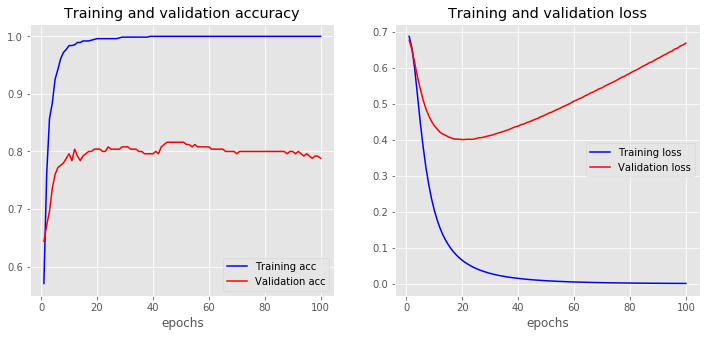

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.xlabel("epochs")
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel("epochs")
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)


以上只是簡單的複習一下基本機器學習做法，以下開始介紹 Word Embedding。

# What Is a Word Embedding?
- Their aim is to map **semantic meaning** into a **geometric space**. This geometric space is then called the **embedding space**.
- 如何取得字詞的embedding space？
    1. 訓練你的NN model時順便訓練出來
    2. 拿別人預先訓練好的來用
- 向量化一個字詞(vectorize text)，在 tokenization 時有以下不同的做法：
    1. 每個 word 用 vector 表達 (最常用的方法)
    2. 每個 character 用 vector 表達
    3. 每個 n-gram 用 vector 表達
- 而將 word 表達成一個 vector，又有兩種常用的做法：
    1. one-hot encoding
    2. word embeddings


## One-Hot Encoding

將 label 的 index 建起來，每一個 label 都有對應的 index number。接著將 label 轉換成 vector，該 label 原本對應到哪個 index number 則在該向量元素上有值1、其餘為0

In [15]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
print(cities)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)

print(city_labels)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

['London', 'Berlin', 'Berlin', 'New York', 'London']
[1 0 0 2 1]


C:\Users\a2437\Anaconda3\envs\NLP_Practice\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

## Word Embeddings

接著我們來試著自己 train 每一個 word 的 embedding space。

首先運用 keras 提供的 `Tokenizer.fit_on_texts` 來將詞彙表建起來 ，接著用 `Tokenizer.texts_to_sequences` 將 training set 與 testing set 用該 tokenizer 轉換成 word-value-mapping vector。

***Note*** *：與前述的 `CountVectorizer` 不同， `CountVectorizer` 直接將每個 sentence 轉換成皆等長的feature vector，`Tokenizer` 則是將 sentence 中的每一個 word 轉換成其對應的 index number，故每一句話的長度不會一樣*

In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

print(sentences_train[0])
print(X_train[0])
# print(vocab_size) # 1747
# print(tokenizer.word_index) # {'the': 1, 'and': 2, 'was': 3, 'i': 4, 'to': 5, ...}


The food was barely lukewarm, so it must have been sitting waiting for the server to bring it out to us.
[1, 10, 3, 282, 739, 25, 8, 208, 30, 64, 459, 230, 13, 1, 124, 5, 231, 8, 58, 5, 67]


`tokenizer.word_index` 只是一個簡單的python 'dict'，儲存著 {word: index} 的對應關係

In [17]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))
type(tokenizer.word_index)

the: 1
all: 43
happy: 320
sad: 450


dict

接著為了訓練模型，需要將每一個 sentence vector 長度變成一樣，此動作稱作 **填補(Padding)**

In [18]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100 # 每一句話最多採計多少個字，後續會作為 input layer size

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  1  10   3 282 739  25   8 208  30  64 459 230  13   1 124   5 231   8
  58   5  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Keras Embedding Layer

接著要來用 keras 透過訓練一個 NN 的同時來訓練出我們的 embedding space 了。

通過 Embedding layer 的資料會是 2D vector，因為每一個字原本只有一個值代表它，現在變成一個 vector 代表它。故如果你的下一層是一個 Dense layer，那麼你可以使用`Flatten()`來將 2D 的輸出變成 1D。

- **input_dim**: the size of the vocabulary
- **output_dim**: the size of the dense vector
- **input_length**: the length of the sequence

In [19]:
from keras.models import Sequential
from keras import layers

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
embedding_dim = 50 # 每一個 word 的 embedding space 的維度

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 137,371
Trainable params: 137,371
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7080


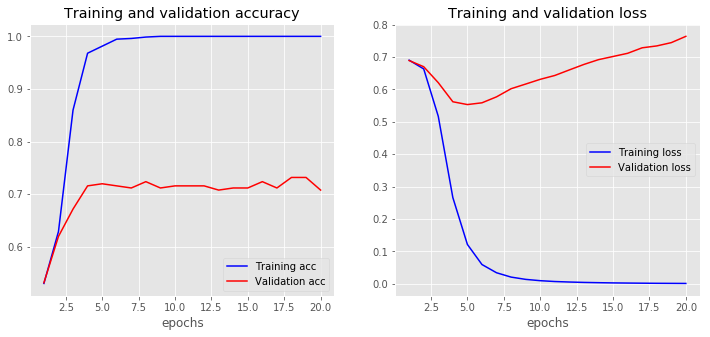

In [20]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

可以看到直接用`flatten` layer 將 embeddings 的輸出資訊(5000維)全拿來用並沒有讓訓練結果比較好。
> 可以理解成將所有字詞的 embeddings 資訊都拿來 train，資訊太多太雜，需要找方法「過濾雜訊」

而較常與 embedding layer 搭配的 layers 為 **MaxPooling1D/AveragePooling1D** 或是 **GlobalMaxPooling1D/GlobalAveragePooling1D** layer，在 NLP 的問題處理上常常使用 **global max pooling** 的方法。
> `MaxPooling1D` 與 `GlobalMaxPooling1D` 的差別在於 `MaxPooling1D` 要指定 kernel size ，取得 kernel size 內的最大值；`GlobalMaxPooling1D` 則是直接取得整個 input 的最大值

> 另外，影像處理較常使用的是 max pooling

故以下重新使用 `GlobalMaxPool1D()` 作為連接 embedding layer 與 dense layer 之間的 pooling layer：

In [21]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


再用同樣的流程 train 一次，就可以得到較好的結果：

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Training Accuracy: 1.0000
Testing Accuracy:  0.8040


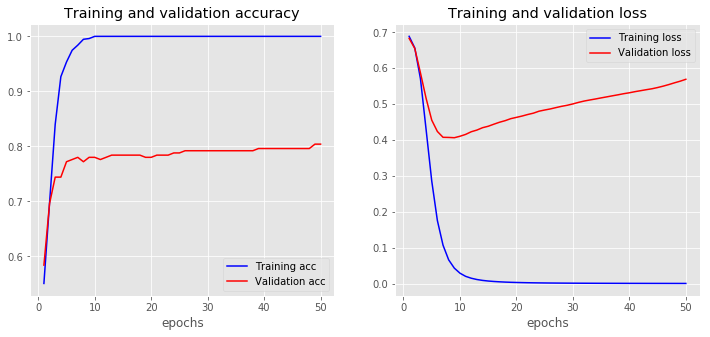

In [22]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Using Pretrained Word Embeddings

再來我們要試著拿別人 pretrain 好的 embeddings 來進一步改善我們的 model。

目前最熱門的 pretrained embeddings 有二：
1. [**Word2Vec**](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) developed by Google
2. [**GloVe**](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation) developed by the Stanford NLP Group

此篇範例以**GloVe**為例，Go ahead and download the 6B (trained on 6 billion words) word embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) (822 MB).
> You can find other word embeddings also on the main [GloVe](https://nlp.stanford.edu/projects/glove/) page. You can find the pretrained Word2Vec embeddings by Google [here](https://code.google.com/archive/p/word2vec/). **If you want to train your own word embeddings**, you can do so efficiently with the [gensim](https://radimrehurek.com/gensim/index.html) Python package which uses Word2Vec for calculation. More details on how to do this [here](https://radimrehurek.com/gensim/models/word2vec.html).

又我們不需要該 pretrained word embeddings 中所有的內容，為了效率考量可以只將在我們資料集中有的字詞抽取出來就好，故用以下 function 來將有用到的部分取出：

In [23]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    './glove.6B.50d.txt',
    tokenizer.word_index, 
    embedding_dim)

檢查 pretrained word embeddings 覆蓋了我們多少的資料集多少比例的詞彙。

覆蓋率有 95% ，只有 5% 的字詞 pretrained word embeddings 沒有涵蓋，可接受。

In [24]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9507727532913566

稍微檢查一下 word embeddings 裡面長甚麼樣：
> `embedding_matrix` 的長度為 1747；`word_index` 的長度為 1746，這是因為 `word_index` 中 index=0 是保留索引，用來標記未在字典裡的字，故長度會少1

In [25]:
print("Length of embedding_matrix: {}".format(embedding_matrix.shape))
print("Length of word_index: {}".format(len(tokenizer.word_index)))
print("Word embeddings in 'index=0'(preserved index):\n{}".format(embedding_matrix[0]))
print("Word embeddings in 'index=1'('the'):\n{}".format(embedding_matrix[1]))

Length of embedding_matrix: (1747, 50)
Length of word_index: 1746
Word embeddings in 'index=0'(preserved index):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Word embeddings in 'index=1'('the'):
[ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027e-01  1.46579996e-01 -9.50950012e-03  1.16579998e-02
  1.02040000e-01 -1.27920002e-01 -8.44299972e-01 -1.21809997e-01
 -1.68009996e-02 -3.32789987e-01 -1.55200005e-01 -2.31309995e-01
 -1.91809997e-01 -1.88230002e+00 -7.67459989e-01  9.90509987e-02
 -4.21249986e-01 -1.95260003e-01  4.00710011e+00 -1.85939997e-01
 -5.22870004e-01 -3.16810012e-01  5.92130003e-04  7.44489999e-03
  1.77780002e-01 -1.58969998e-01  1.20409997e-02 -5.42230010e-02
 -2.98709989e-01 -1.57490000e-01 -3.47579986e-

接著我們使用此 pretrained word embeddings 的參數作為我們的 embedding layer 的初始參數，並且選擇訓練 model 時***不要更新***該 embeddings parameters  (`layers.Embedding(..., trainable=False)`)。
> `Trainable params` 只剩下521個

訓練結果如後：

In [26]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 87,871
Trainable params: 521
Non-trainable params: 87,350
_________________________________________________________________


Training Accuracy: 0.7587
Testing Accuracy:  0.6960


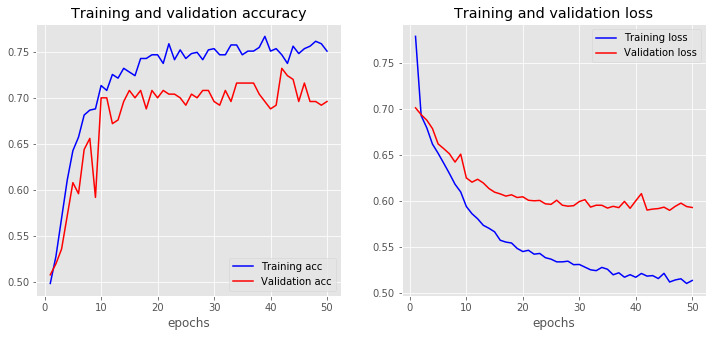

In [27]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

結果很可怕，由於沒有讓 word embeddings 適應我們的資料集，故此結果在預期內。接下來我們試試看 `trainable=True` 會得到甚麼結果：
> `Trainable params`變成87,871，將 embeddings 的參數考慮進來了

In [28]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7880


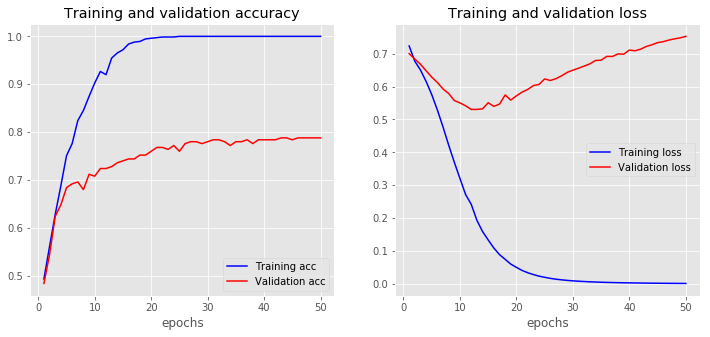

In [29]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

比較上述兩個結果，可以看到允許 word embeddings 的更新是有幫助的，且對於巨量數據集則可以期待加快我們的訓練時間。

但在目前的 case 來說似乎幫助沒這麼顯著，但這並不一定是因為 word embeddings 沒有效果的原因。

後面將進入進階的神經網絡模型，來看看是否對我們這個案例有顯著的幫助。

# Convolutional Neural Networks (CNN)

卷積神經網絡，Convolutional Neural Networks (CNN)，是在影像處理領域相當成功的神經網絡，CNN通常具有多個稱作卷積層(convolutional layers)的隱藏層。

圖片是一個二維的數字矩陣，故你需要一些方法來幫你處理那些被二維數字矩陣表示的圖片邊緣、角落或是特殊的紋理。

而卷積層的設計目的為有效地從上述的例子中提取特徵。卷積層透過包含多組「濾鏡(filters)」、在圖片上滑動來將特定的特徵資訊透過卷積運算給抽取出來。

而今天我們要拿CNN的概念來處理 sequential data，像是由文字組成的句子，而對 sequential data 我們要做的只是執行「一維卷積運算(one dimensional convolutions)」。
> 影像處理一般來說做的則是二維卷積運算

> CNN的介紹另可參考 [[資料分析&機器學習] 第5.1講: 卷積神經網絡介紹(Convolutional Neural Network)](https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC5-1%E8%AC%9B-%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1%E4%BB%8B%E7%B4%B9-convolutional-neural-network-4f8249d65d4f)


而處理一維資訊的示意圖可參考如下：

![1D convolution](img/1D-convolution.png)

Keras 提供多個 CNN layers，今天的案例我們要使用的是 `Conv1D` layer。
而`Conv1D` layer同時提供多個可設參數，今天的案例我們只需要給予**number of filters**, **the kernel size**, and the **activation function**。

In [30]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          174700    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 240,129
Trainable params: 240,129
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8000


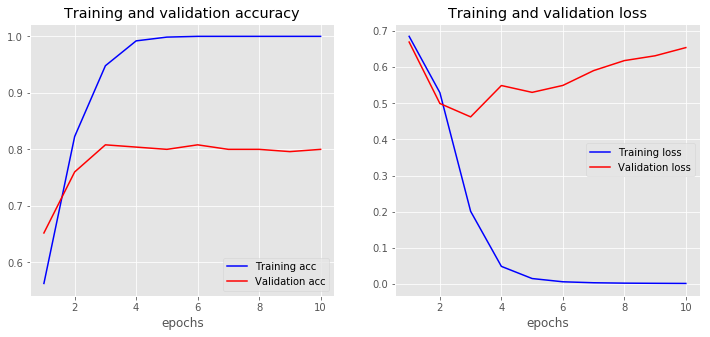

In [31]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

殘念，似乎這組資料集怎麼做，最好僅只有80%的準確率。但其實還是有許多雖然用上了CNN但準確度還是很差的原因可以探討：
- 沒有足夠的訓練樣本
- 缺乏調整**超參數(hyperparameters)**的過程

# Hyperparameters Optimization

所謂的**超參數**，例如上面有些直接設為定值、但其實對模型的準確率來說會有影響的變數還有：
- number of filters；
- kernel size；
- hidden layer 的 neuron 數；
- hidden layer 的 層數；
- activation 的選擇...等等，這些都是可調整的變數。

最常用的手段就是所謂的 **grid search**，相信大家都很熟悉了。

另一個常用的方法則是 **random search**，很單純地將所有可能的參數做隨機組合。後面的範例將以random search為例。

接著為了方便我們調整超參數，將上述創建模型的步驟用 function 包起來：
> 原文中並未採用 pretrained word embeddings，在此示範的是每個 model 創建時會吃到 embeddings

In [32]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen, pre_trained_weights):
    model = Sequential()
    model.add(layers.Embedding(
                vocab_size, 
                embedding_dim,
                input_length=maxlen,
                weights=[pre_trained_weights],
                trainable=True
             ))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [42]:
%%time

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    embedding_matrix = create_embedding_matrix(
        './glove.6B.50d.txt',
        tokenizer.word_index, 
        embedding_dim)
    
    # Parameter grid for grid search
    param_grid = dict(
        num_filters=[32, 64, 128],
        kernel_size=[3, 5, 7],
        vocab_size=[vocab_size],
        embedding_dim=[embedding_dim],
        maxlen=[maxlen],
        pre_trained_weights=[embedding_matrix]) ### pass embedding_matrix as parameters
    
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, 
                            batch_size=10,
                            verbose=False)
    
    grid = RandomizedSearchCV(estimator=model, 
                              param_distributions=param_grid,
                              cv=4, 
                              n_iter=5)
    
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)
    
    # Print results to screen
    print("Running {} data set".format(source))
    print("Best Accuracy : {:.4f}".format(grid_result.best_score_))
    print("Best parameters:\n    {}".format(grid_result.best_params_))
    print("Test Accuracy : {:.4f}".format(test_accuracy))



Running grid search for data set : amazon
Running amazon data set
Best Accuracy : 0.8379
Best parameters:
    {'vocab_size': 4603, 'pre_trained_weights': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.26818001,  0.14346001, -0.27877   , ..., -0.63209999,
        -0.25027999, -0.38097   ],
       ...,
       [ 0.69103003, -0.31466001, -1.56620002, ...,  0.66382003,
        -0.48172   ,  0.73137999],
       [ 0.45596999,  0.014753  , -0.55712998, ...,  1.15279996,
         0.42357999, -0.44042999],
       [-0.24195001,  0.62722999,  0.30823001, ...,  0.16113999,
        -0.20556   , -0.049197  ]]), 'num_filters': 128, 'maxlen': 100, 'kernel_size': 7, 'embedding_dim': 50}
Test Accuracy : 0.8472
Running grid search for data set : imdb
Running imdb data set
Best Accuracy : 0.8379
Best parameters:
    {'vocab_size': 4603, 'pre_tra

與原文、未使用pretrained word embeddings結果比較：

Running **amazon** data set

```bash
# with pretrained word embeddings
Best Accuracy : 0.8379
Best parameters:
{'vocab_size': 4603, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 7, 'embedding_dim': 50}
Test Accuracy : 0.8472

# without pretreined word embeddings
Best Accuracy : 0.8122
{'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8457
```

Running **imdb** data set

```bash
# with pretrained word embeddings
Best Accuracy : 0.8379
Best parameters:
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8311

# without pretreined word embeddings
Best Accuracy : 0.8161
{'vocab_size': 4603, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8210
```

Running **yelp** data set

```bash
# with pretrained word embeddings
Best Accuracy : 0.8413
Best parameters:
{'vocab_size': 4603, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8544

# without pretreined word embeddings
Best Accuracy : 0.8127
{'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 7, 'embedding_dim': 50}
Test Accuracy : 0.8384
```



# Conclusion

本篇教學涵蓋了：
- 運用 bag-of-words model 搭配 Logistic Regression/CNN 來處理基本的文本分類問題
- word embeddings 的訓練步驟及如何使用 pretrained word embeddings
- keras 如何搭配 cross-validation 進行超參數的調教